In [1]:
'''Path to LIBRARIES '''
import os, sys
LibPath = '../'
if LibPath in sys.path:
    print('YES')
else:
    print('NO, we\'ll add it now')
    sys.path.append(LibPath)
import warnings
warnings.filterwarnings("ignore")

NO, we'll add it now


In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from scipy.linalg import hankel
from sklearn.manifold import TSNE

from Libraries.Util import MLS, Norm01
from Libraries.features import CEmbDim

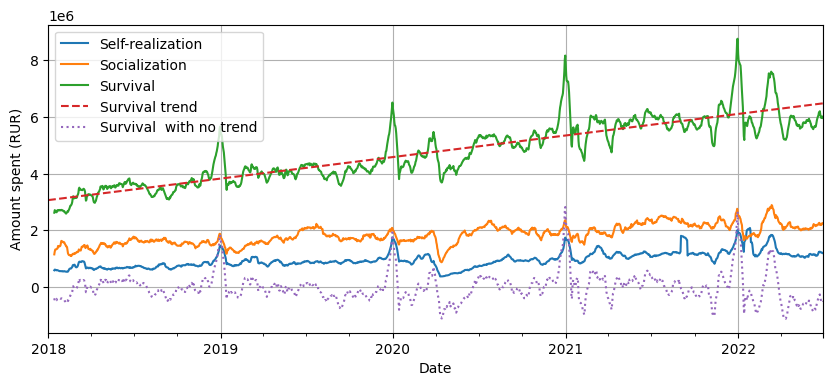

In [3]:
'''Target series to forecast '''
data=pd.read_csv('sssr.csv', parse_dates=['idate'])
data.set_index('idate', inplace=True)
data.drop(data['2022-07-01':].index, inplace=True)
data.drop('money', axis=1).rolling(14).mean().plot(grid=True, figsize=(10,4))

plt.xlabel('Date')
plt.ylabel('Amount spent (RUR)')
#plt.savefig('data.png', dpi=600, pad_inches=0.1, facecolor='white')

x=np.arange(len(data))
a,b = MLS(x, data.survival.values)
surv_trend=a*x+b
plt.plot(data.index, surv_trend, ls='--' ) 
plt.plot(data.survival.rolling(14).mean()-surv_trend, ls=':' )
plt.legend(['Self-realization', 'Socialization', 'Survival', 'Survival trend', 'Survival  with no trend'])

plt.show()

(2080.5687184910107, 3063271.980783852, 10)

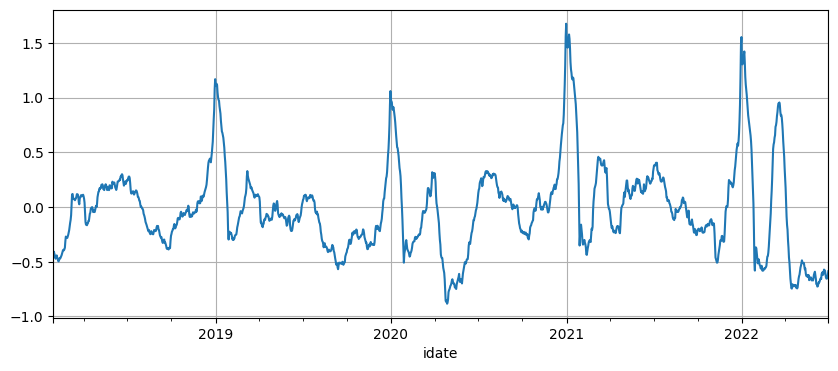

In [4]:
value='survival'#'self_realization'#'socialization'#money'
x=np.arange(len(data))
a,b = MLS(x, data[value].values)
val_trend=a*x+b
ser=(data[value].rolling(28).mean()-val_trend).dropna()/1e6
edim=CEmbDim(ser.values)
ser.plot(figsize=(10,4), grid=True)
a,b, edim

In [5]:
print(ser.values[-edim:].round(2))
traject=hankel(ser.values, r=None)[:-edim+1,:edim]
traject

[-0.57 -0.58 -0.58 -0.62 -0.64 -0.65 -0.65 -0.64 -0.62 -0.59]


array([[-0.45999294, -0.40730502, -0.4233287 , ..., -0.4417227 ,
        -0.46285969, -0.46611844],
       [-0.40730502, -0.4233287 , -0.43809991, ..., -0.46285969,
        -0.46611844, -0.49155046],
       [-0.4233287 , -0.43809991, -0.45381885, ..., -0.46611844,
        -0.49155046, -0.49681632],
       ...,
       [-0.61981458, -0.60183986, -0.57151543, ..., -0.65362529,
        -0.65382041, -0.64214729],
       [-0.60183986, -0.57151543, -0.5793947 , ..., -0.65382041,
        -0.64214729, -0.61853632],
       [-0.57151543, -0.5793947 , -0.5808003 , ..., -0.64214729,
        -0.61853632, -0.58618751]])

In [6]:
modt = TSNE(learning_rate='auto', init='pca', random_state=21)
# Обучаем модель
transformed = modt.fit_transform(traject)
# Представляем результат в двумерны координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

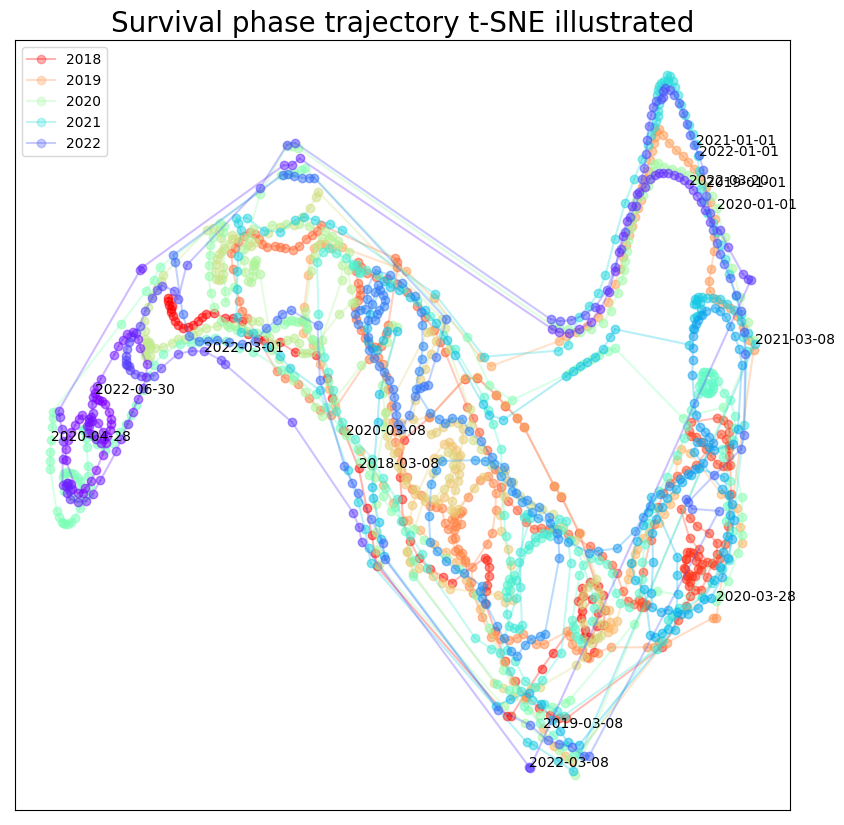

In [7]:
cmap=matplotlib.colormaps['rainbow']
fig, ax=plt.subplots(1, figsize=(10,10))
plt.title(value.capitalize().replace('_', '-')+' phase trajectory t-SNE illustrated', fontsize=20)
days=ser.index.strftime('%Y-%m-%d').values
for i in range(traject.shape[0]-1):
    d=days[i+edim]
    if  d in ['2018-02-08','2019-01-01','2020-01-01','2021-01-01', '2022-01-01']:
        label=d[:4]
    else:
        label=None 
    if d in ['2019-01-01','2020-01-01','2021-01-01', '2022-01-01','2022-06-30',
             '2018-03-08','2019-03-08','2020-03-08','2021-03-08', '2022-03-08',
             '2022-03-01', '2022-03-20', '2020-03-28','2020-04-28']:
        plt.text(x_axis[i], y_axis[i], d)
    ax.plot([x_axis[i],x_axis[i+1]], [y_axis[i],y_axis[i+1]], marker='o', color=cmap(1-i/traject.shape[0]), alpha=0.3, label=label)
plt.xticks(())
plt.yticks(())
plt.legend()
t=np.arange(0, len(ser), len(ser)//10)
#plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), cax=None, ax=ax, ticks=matplotlib.ticker.LinearLocator(numticks=5, presets=(2018 ,2022)))
plt.show()

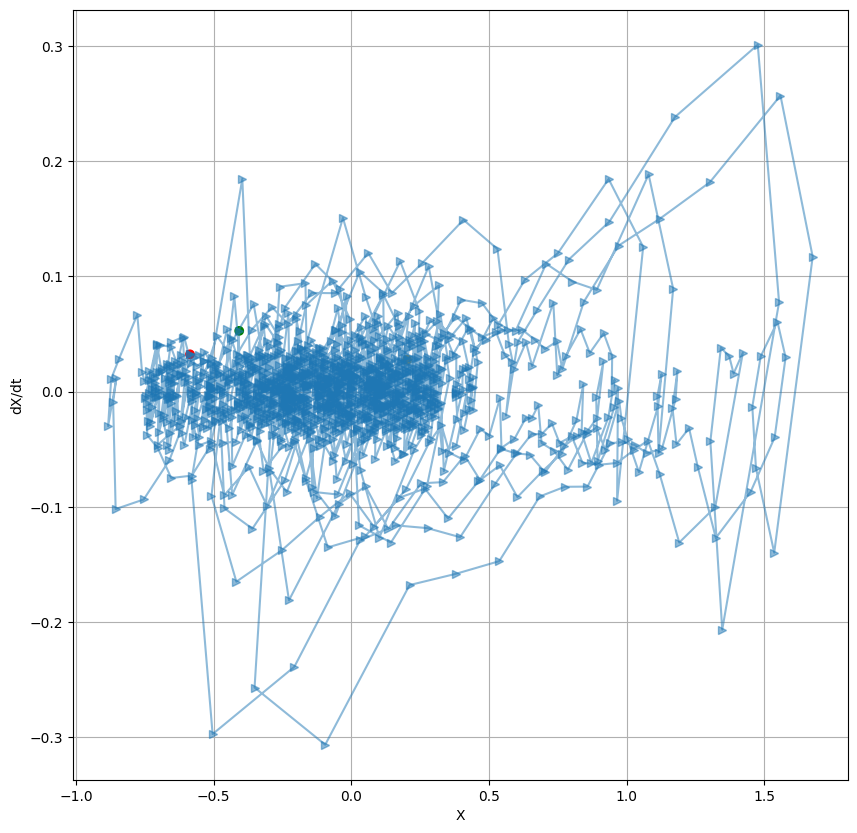

In [8]:
s=ser#.loc['2019-12-31':'2021-01-02']
plt.figure(figsize=(10,10))
plt.plot(s[1:], s.diff()[1:], marker='>', alpha=0.5)
plt.scatter([s[1],s[100], s[-1]],[s.diff()[1],s.diff()[100], s.diff()[-1]], color=['g','orange','r'])
plt.xlabel('X')
plt.ylabel('dX/dt')
plt.grid()
plt.show()

<AxesSubplot:xlabel='idate'>

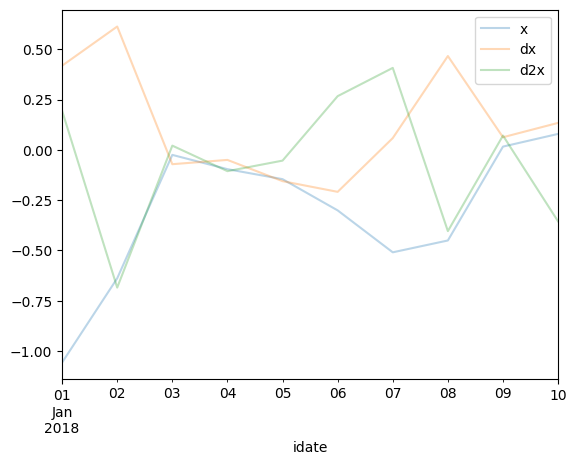

In [9]:
value='socialization'
x=np.arange(len(data))
a,b = MLS(x, data[value].values)
val_trend=a*x+b
s=(data[value]-val_trend).dropna()/1e6
tab=pd.DataFrame({'x':s, 'dx':s.diff().shift(-1), 'd2x':s.diff().diff().shift(-2)}).dropna()
tab.iloc[:10].plot(alpha=0.3)

In [10]:
'''d2x=-a*dx-b*x'''
from sklearn.linear_model import LinearRegression as LR
X=-tab[['dx','x']]['2020-01-15':'2020-06-15']
y=tab['d2x']['2020-01-15':'2020-06-15']
reg = LR().fit(X, y)
print('R2 %.2f'%reg.score(X, y))
print(reg.coef_,  reg.intercept_)
b,c=reg.coef_
d=b**2-4*c
if d<0:
    print('%.3f+%.3fi, %.3f-%.3fi'%(-b, np.sqrt(-d), -b, np.sqrt(-d)))
else:
    print('%.3f, %.3f'%(-b+np.sqrt(d), -b-np.sqrt(d)), d)

R2 0.78
[1.6730713  0.36220692] -0.07834264436189914
-0.511, -2.835 1.3503398991821192


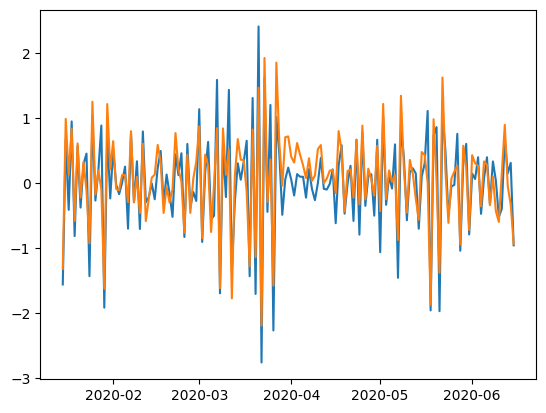

In [11]:
y2=(X*np.array([b,c])).sum(axis=1)
plt.plot(y)
plt.plot(y2)


In [27]:
ind=tab.index

winds=[5,7,14,28,56,112, 182, 365, 730, 1095, 1460]
r2 = []
meanb, meanc = [],[]
for win in winds:
    bb,cc,scores = [],[],[]
    for i in range(len(ind)-win):
        X=tab[['dx','x']][ind[i]:ind[i+win]]
        y=tab['d2x'][ind[i]:ind[i+win]]
        reg = LR().fit(X, y)
        scores.append(reg.score(X, y))
        bb.append(-reg.coef_[0])
        cc.append(-reg.coef_[1])
    meanb.append(bb)
    meanc.append(cc)
    r2.append(scores) 

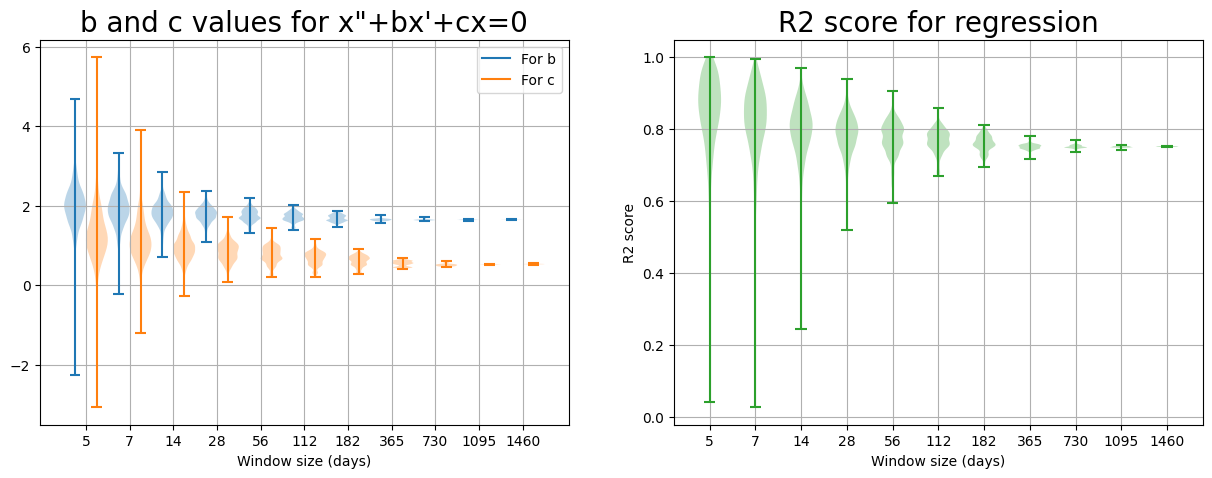

In [51]:
cmap=matplotlib.colormaps['tab10']
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.violinplot(meanb, positions=np.arange(len(winds))-.25)
plt.violinplot(meanc, positions=np.arange(len(winds))+.25)
plt.plot([], label='For b', c=cmap(0))
plt.plot([], label='For c', c=cmap(1))
plt.title('b and c values for x\"+bx\'+cx=0', size=20)
plt.xticks(np.arange(len(winds)), winds)
plt.xlabel('Window size (days)')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
viol=plt.violinplot(r2)
for pc in viol['bodies']:
    pc.set_facecolor(cmap(2))
    #pc.set_edgecolor(cmap(2))
viol['cbars'].set_color(cmap(2))
viol['cmins'].set_color(cmap(2))
viol['cmaxes'].set_color(cmap(2))
plt.xticks(np.arange(len(winds))+1, winds)
plt.xlabel('Window size (days)')
plt.ylabel('R2 score')
plt.title('R2 score for regression',  size=20)

plt.grid()
plt.show()

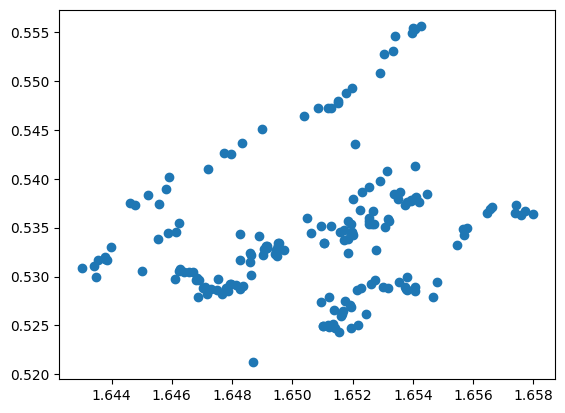

In [56]:
plt.scatter(bb,cc)

In [190]:
'''News topics embedded into time-series'''
realdat=tab['x']['2020-03-01':'2020-09-01']
topics=pd.read_csv('TOPICS.csv', index_col=0)['2020-03-01':'2020-09-01']

topics.columns

Index(['-1_петербург_коронавиру_россия', '0_петербург_россия_рассказыва',
       '1_полиция_полицейски_наркотик', '2_коронавиру_сутки_человек',
       '3_год_2022_2020', '4_белоруссия_ленинградс_область',
       '5_мотоциклис_велосипеди_велосипед', '6_парковка_парк_платный',
       '7_театр_спектакль_мариинский', '8_qr_код_цифровой',
       '9_маска_носить_медицински', '10_кафе_ресторан_кофе',
       '11_apple_iphone_яблоко', '12_эстония_голландия_новый',
       '13_учитель_учительниц_математика', '14_операция_онлайн_военный',
       '15_психолог_депрессия_психиатр', '16_афганистан_мусульмани_азербайджа',
       '17_граффити_художник_закрашиват', '18_медведь_пиво_медвежонок',
       '19_мужчина_стрельба_район', '20_электричес_электросам_электромоб',
       '21_секунда_60_фонтанка', '22_франция_французски_макрон',
       '23_венесуэла_мадуро_сша', '24_природопол_экологичес_комитет',
       '25_израиль_израильски_сирия', '26_гей_порно_детский',
       '27_интеллект_искусствен_пластическ'

<AxesSubplot:>

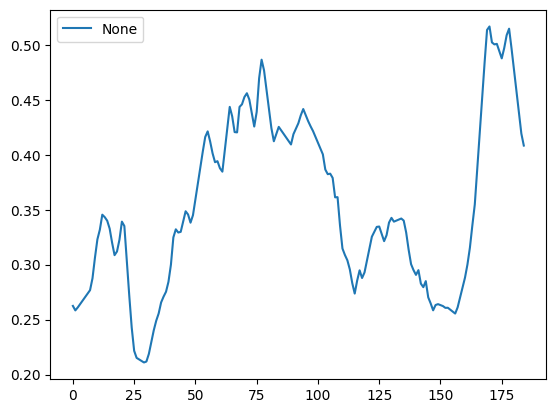

In [191]:
tpc=pd.DataFrame()
tpc['date']=list(realdat.index.strftime('%Y-%m-%d'))
x=np.arange(len(realdat))[np.in1d(np.array(realdat.index.strftime('%Y-%m-%d')), topics.index.values)]
for c in topics.columns[:]:
    tpc[c]=np.interp(np.arange(len(realdat)), x, topics[c].values)
    tpc[c]=Norm01(tpc[c].values)[0]
#tpc[tpc.columns[:7]].plot(legend=True) 
tpc.median(axis=1).plot(legend=True)

1.650671945990889 0.5343846419354187
D = 0.59, h= 0.994


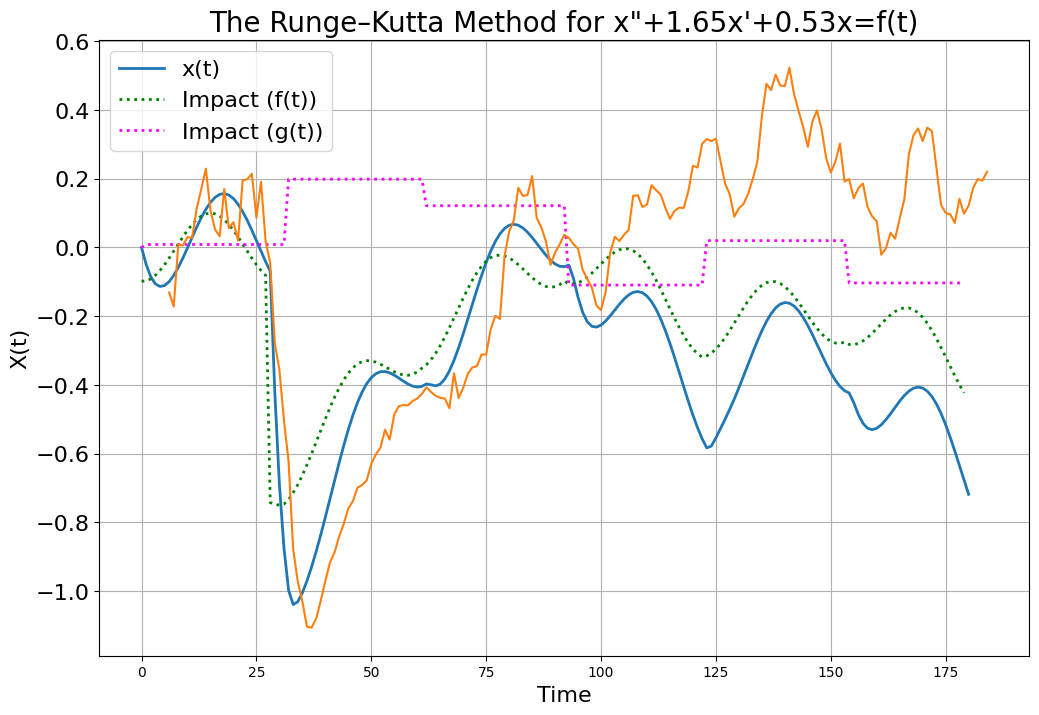

In [214]:
''' Рунге-Кутта IV порядка x"+ax'+bx=f(t) с начальными условиями с матрицами'''

realdat=tab['x']['2020-03-01':'2020-09-01']
dsin=np.sin(realdat.index.day.values*2*np.pi/30)
dcos=np.cos(realdat.index.day.values*2*np.pi/30)

def f(t): #Внешнее воздействие по x и x'
    x=0
    if t<28:
        x=0
    else:
        x=-tpc['-1_петербург_коронавиру_россия'].values[int(t)]/1.5
    # elif t<42:
    #     x=-.5
    # else:
    #     x=0
    if t<1:
        dx=0
    else:
        dx=-tpc['-1_петербург_коронавиру_россия'].diff().values[int(t)]*10
        
    # if abs(t-5)<1:
    #     dx+=.25
    # if abs(t-40)<1:
    #     dx-=1.0
    return [x-dcos[int(t)-1]/10, dx]

a,b = sum(bb)/len(bb), sum(cc)/len(cc)   # коэффициенты x"+ax'+bx=f(t)
print(a,b)
x = [0.]     # Начальные условия для x(t)
dx = [0.]    # для dx/dt

T=np.arange(0,180)
h=(T[-1]-T[0])/len(T)
A=np.array([[0.,1],[-b,-a]]).reshape(2,2)
for t in T:
    Y=np.array([[x[-1],dx[-1]]]).T
    k1=(np.dot(A,Y)+np.array([f(t)]).T)*h
    k2=(np.dot(A,(Y+k1/2))+np.array([f(t+h/2)]).T)*h
    k3=(np.dot(A,(Y+k2/2))+np.array([f(t+h/2)]).T)*h
    k4=(np.dot(A,(Y+k3))+np.array([f(t+h)]).T)*h
    Y1=Y+(k1+2*k2+2*k3+k4)/6
    x.append(Y1[0,0])
    dx.append(Y1[1,0])

x=np.array(x)*b
dx=np.array(dx)*b     
plt.figure(figsize=(12,8))
plt.plot(x, lw=2, label='x(t)')
#plt.plot(dx, lw=2, label='dx/dt')
plt.plot([f(t)[0] for t in T], c='green', ls=':',lw=2, label='Impact (f(t))')
plt.plot([f(t)[1] for t in T], c='magenta', ls=':',lw=2, label='Impact (g(t))')
xti=np.arange(0,len(T)+1,len(T)//30)
#plt.xticks(xti, np.arange(len(xti)), size=16)
plt.yticks(size=16)
plt.title('The Runge–Kutta Method for x\"+%.2fx\'+%.2fx=f(t)'%(a,b), size=20)
plt.xlabel('Time', size=16)
plt.ylabel('X(t)', size=16)
plt.legend(fontsize=16)
plt.grid()

plt.plot(realdat.rolling(7).mean().values)

print('D = %.2f, h= %.3f'%(a**2-4*b, h))

In [110]:
d=a**2-4*b
print(a, b, d)
x1,x2=(-a+np.sqrt(d))/2, (-a-np.sqrt(d))/2
x1,x2

1.650671945990889 0.5343846419354187 0.5871793055396735


(-0.44219784335429485, -1.2084741026365942)

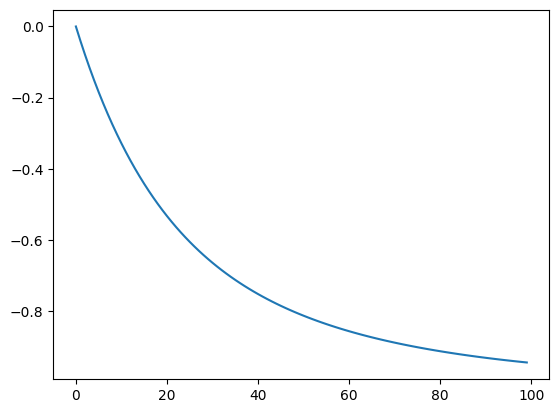

In [84]:
t=np.linspace(0, 5, 100)
y0=-1
y=np.exp(t*x1)+np.exp(t*x2)
plt.plot(y/2+y0)